In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
import time
import numpy as np
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt

### <b>Load data</b>
Visualize and check the binary distribution

In [2]:
# load data
data = np.load("phaselink.npz")
X = data["X"]   # (100000, np, 5),where np is a sliding window length (length of a subsequence)
# 5 dimensions are lat, lon, time, type, zero padding
Y = data["Y"]   # the first pick of the sequence

Text(0.5, 0.98, 'yellow: S-wave, purple: P-wave')

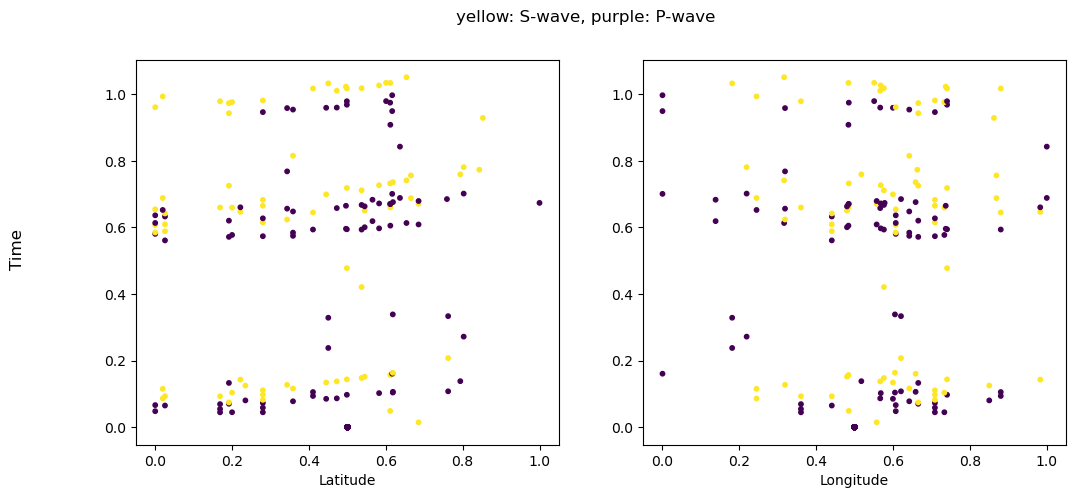

In [3]:
#  plot some seq
ind1   = 5300  # plot the kth sequence
ind2   = ind1+1

lat = X[ind1:ind2, :, 0].flatten()
lon = X[ind1:ind2, :, 1].flatten()
time_ = X[ind1:ind2, :, 2].flatten()
type_ = X[ind1:ind2, :, 3].flatten()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
scatter0 = axes[0].scatter(lat, time_, c=type_, label='Latitude', s=10)
scatter1 = axes[1].scatter(lon, time_, c=type_, label='Longitude', s=10)

# label
axes[0].set_xlabel('Latitude')
axes[1].set_xlabel('Longitude')
fig.supylabel('Time')
fig.suptitle('yellow: S-wave, purple: P-wave')

In [4]:
# distribution of labels

# Y label = 1
num_class1 = np.sum(Y)
num_total = Y.size
# Y label = 0
num_class0 = num_total - num_class1
# print
print(f"Number of class 1 (associate with the root) samples: {num_class1}, proportion: {num_class1/num_total:.4f}")
print(f"Number of class 0 (unrelated with the root) samples: {num_class0}, proportion: {num_class0/num_total:.4f}")


Number of class 1 (associate with the root) samples: 1331447, proportion: 0.0266
Number of class 0 (unrelated with the root) samples: 48668553, proportion: 0.9734


### <b>Build many-to-many RNN and a trainer</b>
see below for the model and the trainer

In [5]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1):
        """
        Args:
            input_size: number of input features
            hidden_size: number of hidden units
            output_size: number of output features (default: 1, which class it belongs to)
        """
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        
        # Input to hidden layer
        self.input_to_hidden = nn.Linear(input_size, hidden_size)
        
        # Hidden to hidden layer (recurrent connection)
        self.hidden_to_hidden = nn.Linear(hidden_size, hidden_size)
        
        # Hidden to output layer
        self.hidden_to_output = nn.Linear(hidden_size, output_size)
        
        # Activation functions
        self.sigmoid = nn.Sigmoid()
        self.tanh    = nn.Tanh()

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        outputs = []
        
        # Initialize hidden state
        h_t = torch.zeros(batch_size, self.hidden_size).to(x.device)
        
        # Process each time step
        for t in range(seq_len):
            x_t = x[:, t, :]
            h_t = self.tanh(self.input_to_hidden(x_t) + self.hidden_to_hidden(h_t))
            # compute output layer
            output_t = self.sigmoid(self.hidden_to_output(h_t))
            # append
            outputs.append(output_t.unsqueeze(1))

        # Output layer
        output = torch.cat(outputs, dim=1) # （batch_size, output_size)
        
        return output

In [6]:
class Trainer:
    def __init__(self, model, train_loader, val_loader, criterion, optimizer, device):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
    
    def train(self, num_epochs):
        self.model.to(self.device)

        # ========== training loop ==========
        self.model.train()
        # loss precision recall
        train_losses = []
        train_precisions = []
        train_recalls = []
        test_losses = []
        test_precisions = []
        test_recalls = []

        # starting time
        start_time = time.time()
        # loop
        for epoch in range(num_epochs):
            epoch_losses = []
            all_preds = []
            all_labels = []
            for batch_X, batch_Y in self.train_loader:
                batch_X = batch_X.to(self.device).float()
                batch_Y = batch_Y.to(self.device).float()
                
                # Forward pass
                outputs = self.model(batch_X).squeeze(-1)
                loss = self.criterion(outputs, batch_Y)
                
                # Backward pass and optimization
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                # Record loss
                epoch_losses.append(loss.item())
                
                # Predictions
                preds = (outputs >= 0.5).float()
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(batch_Y.cpu().numpy())
            
            # Compute metrics
            epoch_loss = np.mean(epoch_losses)
            all_labels = np.array(all_labels).flatten()
            all_preds  = np.array(all_preds).flatten()
            epoch_precision = precision_score(all_labels, all_preds, average=None, zero_division=0)
            epoch_recall    = recall_score(all_labels, all_preds, average=None, zero_division=0)
            
            train_losses.append(epoch_loss)
            train_precisions.append(epoch_precision)
            train_recalls.append(epoch_recall)
            
            print(
                f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f} | " + 
                f"Precision for class 0: {epoch_precision[0]:.4f}, class 1: {epoch_precision[1]:.4f} | " +
                f"Recall for class 0: {epoch_recall[0]:.4f}, class 1: {epoch_recall[1]:.4f} "
            )

            # ========== testing loop ==========
            self.model.eval()

            with torch.no_grad():
                all_preds = []
                all_labels = []
                for batch_X, batch_Y in self.val_loader:
                    batch_X = batch_X.to(self.device).float()
                    batch_Y = batch_Y.to(self.device).float()
                    
                    # Forward pass
                    outputs = self.model(batch_X).squeeze(-1)
                    loss = self.criterion(outputs, batch_Y)
                    
                    # Predictions
                    preds = (outputs >= 0.5).float()
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(batch_Y.cpu().numpy())
            
                # Compute metrics
                test_loss = np.mean(test_losses)
                all_labels = np.array(all_labels).flatten()
                all_preds  = np.array(all_preds).flatten()
                test_precision = precision_score(all_labels, all_preds, average=None, zero_division=0)
                test_recall = recall_score(all_labels, all_preds, average=None, zero_division=0)
                
                print(
                    f"Test Loss: {test_loss:.4f} | " + 
                    f"Precision for class 0: {test_precision[0]:.4f}, class 1: {test_precision[1]:.4f} | " +
                    f"Recall for class 0: {test_recall[0]:.4f}, class 1: {test_recall[1]:.4f} "
                    )
                
                test_losses.append(test_loss)
                test_precisions.append(test_precision)
                test_recalls.append(test_recall)
            
            # ========== test of convergence ==========
            if epoch > 5:
                if abs(train_losses[-1] - train_losses[-2]) < 1e-4:
                    print("Convergence reached, stopping training.")
                    break
                
        # total time
        end_time = time.time()
        print(f"Total training time: {end_time - start_time:.2f} seconds")
        return (train_losses, train_precisions, train_recalls), (test_losses, test_precisions, test_recalls)

In [7]:
# split dataset into train and test sets, 80% and 20%, each unit is a sequence
batch_size = 256
n_picks, len_seq, n_features = X.shape

X_tensor = torch.tensor(X, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32)
dataset = TensorDataset(X_tensor, Y_tensor)
train_size = int(0.8 * n_picks)
test_size  = n_picks - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [8]:
hidden_size = 16
model       = RNN(n_features, hidden_size)
# use SGD optimizer
optimizer   = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion   = nn.BCELoss()
device      = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
# # just a try (to make sure things work)
# # trainer
# trainer = Trainer(
#     model = model, 
#     optimizer = optimizer, 
#     train_loader = train_loader, 
#     val_loader = test_loader, 
#     criterion = criterion, 
#     device = device
#     )
# # train
# num_epochs = 10
# train_metrics, test_metrics = trainer.train(num_epochs)

In [ ]:
# try learning rate of 1, 0.1, 0.01, 0.001, 0.0001, n_epochs=50
lrs = [0.01, 0.1, 0.001, 1, 0.0001]
new_epochs = 100

train_losses_all = {}
test_losses_all  = {}
train_precisions_all = {}
test_precisions_all  = {}
train_recalls_all = {}
test_recalls_all  = {}

for lr in lrs:
    print(f"\nTraining with learning rate: {lr}")
    # re-initialize model and optimizer
    model = RNN(n_features, hidden_size)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    
    # trainer
    trainer = Trainer(
        model = model, 
        optimizer = optimizer, 
        train_loader = train_loader, 
        val_loader = test_loader, 
        criterion = criterion, 
        device = device
        )
    
    # train
    train_metrics, test_metrics = trainer.train(new_epochs)
    
    # store metrics
    train_losses_all[lr] = train_metrics[0]
    train_precisions_all[lr] = train_metrics[1]
    train_recalls_all[lr] = train_metrics[2]
    
    test_losses_all[lr] = test_metrics[0]
    test_precisions_all[lr] = test_metrics[1]
    test_recalls_all[lr] = test_metrics[2]


Training with learning rate: 0.01
Epoch [1/100], Loss: 0.1321 | Precision for class 0: 0.9735, class 1: 0.0508 | Recall for class 0: 0.9941, class 1: 0.0116 


/home/zhe2/anaconda3/envs/pace/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/zhe2/anaconda3/envs/pace/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Test Loss: nan | Precision for class 0: 0.9736, class 1: 0.0000 | Recall for class 0: 1.0000, class 1: 0.0000 
Epoch [2/100], Loss: 0.0630 | Precision for class 0: 0.9733, class 1: 0.3494 | Recall for class 0: 1.0000, class 1: 0.0001 
Test Loss: nan | Precision for class 0: 0.9736, class 1: 0.0000 | Recall for class 0: 1.0000, class 1: 0.0000 
Epoch [3/100], Loss: 0.0542 | Precision for class 0: 0.9737, class 1: 0.4996 | Recall for class 0: 0.9996, class 1: 0.0147 
Test Loss: nan | Precision for class 0: 0.9746, class 1: 0.5070 | Recall for class 0: 0.9989, class 1: 0.0423 


In [ ]:
# save the dict
np.savez(
    "rnn_training_metrics.npz",
    train_losses_all = train_losses_all,
    test_losses_all  = test_losses_all,
    train_precisions_all = train_precisions_all,
    test_precisions_all  = test_precisions_all,
    train_recalls_all = train_recalls_all,
    test_recalls_all  = test_recalls_all
)

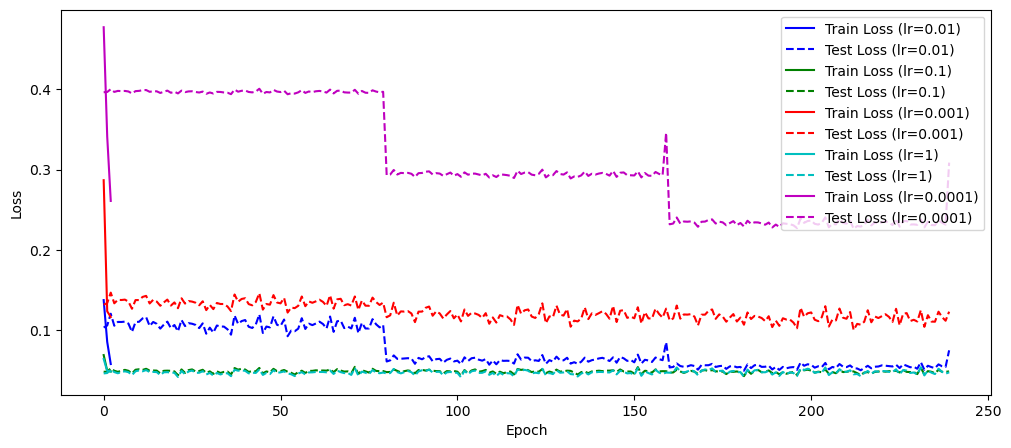

In [ ]:
# plot loss
colors = ['b', 'g', 'r', 'c', 'm']
plt.figure(figsize=(12, 5))
for i, lr in enumerate(lrs):
    plt.plot(train_losses_all[lr], color=colors[i], label=f'Train Loss (lr={lr})')
    plt.plot(test_losses_all[lr], color=colors[i], linestyle='--', label=f'Test Loss (lr={lr})')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

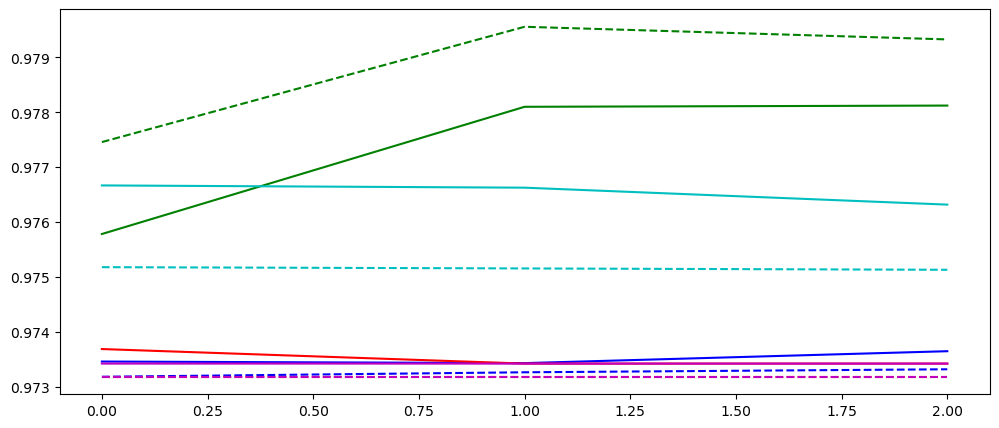

In [ ]:
# plot precision for class 0
plt.figure(figsize=(12, 5))
for i, lr in enumerate(lrs):
    train_precisions = np.array(train_precisions_all[lr])
    test_precisions  = np.array(test_precisions_all[lr])
    plt.plot(train_precisions[:, 0], color=colors[i], label=f'Train Precision Class 0 (lr={lr})')
    plt.plot(test_precisions[:, 0], color=colors[i], linestyle='--', label=f'Test Precision Class 0 (lr={lr})')

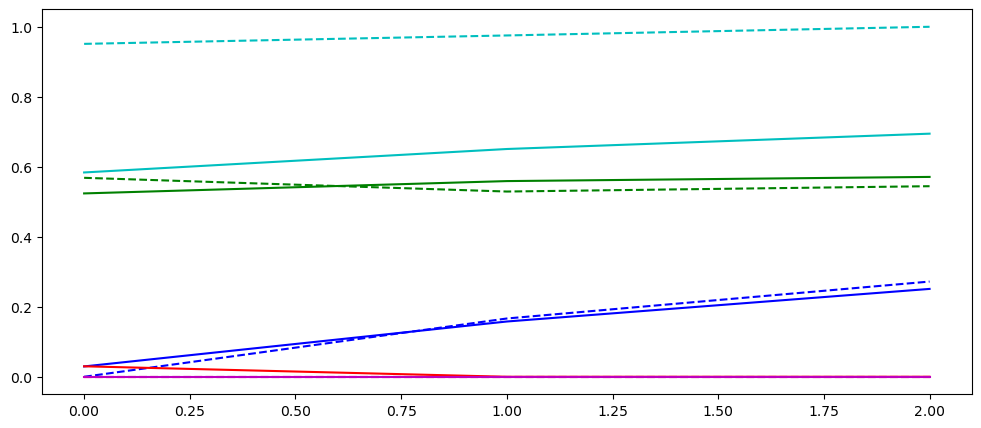

In [ ]:
# precision for class 1
plt.figure(figsize=(12, 5))
for i, lr in enumerate(lrs):
    train_precisions = np.array(train_precisions_all[lr])
    test_precisions  = np.array(test_precisions_all[lr])
    plt.plot(train_precisions[:, 1], color=colors[i], label=f'Train Precision Class 1 (lr={lr})')
    plt.plot(test_precisions[:, 1], color=colors[i], linestyle='--', label=f'Test Precision Class 1 (lr={lr})')

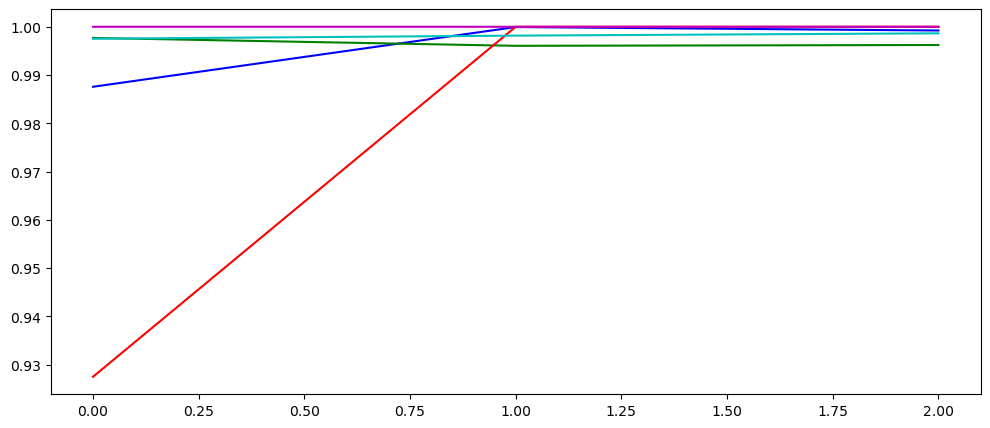

In [ ]:
# recall for class 0
plt.figure(figsize=(12, 5))
for i, lr in enumerate(lrs):
    train_recalls = np.array(train_recalls_all[lr])
    test_recalls  = np.array(test_recalls_all[lr])
    plt.plot(train_recalls[:, 0], color=colors[i], label=f'Train Recall Class 0 (lr={lr})')
    # plt.plot(test_recalls[:, 0], color=colors[i], linestyle='--', label=f'Test Recall Class 0 (lr={lr})')

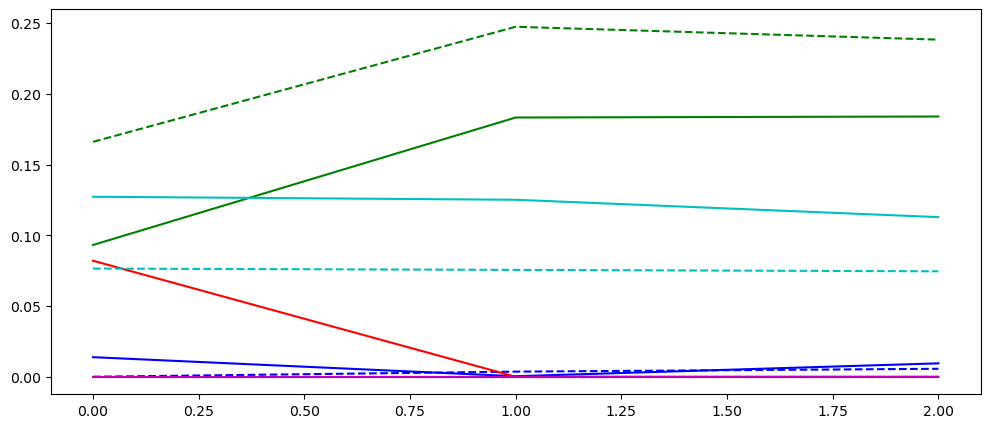

In [ ]:
# recall for class 1
plt.figure(figsize=(12, 5))
for i, lr in enumerate(lrs):
    train_recalls = np.array(train_recalls_all[lr])
    test_recalls  = np.array(test_recalls_all[lr])
    plt.plot(train_recalls[:, 1], color=colors[i], label=f'Train Recall Class 1 (lr={lr})')
    plt.plot(test_recalls[:, 1], color=colors[i], linestyle='--', label=f'Test Recall Class 1 (lr={lr})')